3. Feature Engineering Automation

In [1]:
import pandas as pd

def engineer_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')  # Ensure proper order for rolling

    # Time-based features
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0 = Monday
    df['month'] = df['timestamp'].dt.month

    # Rolling 7-day mean for emissions
    df['emissions_rolling_7d'] = df['emissions'].rolling(window=7, min_periods=1).mean()

    # Emission intensity (emissions per unit production)
    df['emission_intensity'] = df['emissions'] / df['production']

    return df


c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.feature_selection import SelectKBest, f_regression

def select_top_features(df, target_col='target', k=5):
    # Drop non-numeric columns and isolate features
    features = df.drop(columns=['timestamp', target_col])
    X = features.select_dtypes(include='number')
    y = df[target_col]

    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)

    selected_cols = X.columns[selector.get_support()]
    return X[selected_cols], selected_cols


Once the model is trained, SHAP (SHapley Additive exPlanations) allows us to visualize and quantify how much each feature contributes to each prediction. This helps verify whether the features we engineered — like rolling means or emission intensity — actually influence the model the way we expected.

In [3]:
import shap
from sklearn.ensemble import RandomForestRegressor

def explain_with_shap(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Summary plot (importance of features)
    shap.summary_plot(shap_values, X, plot_type="bar")


Full Pipeline Example (Mini Demo)

Selected features: ['emissions', 'production', 'day_of_week', 'emissions_rolling_7d', 'emission_intensity']


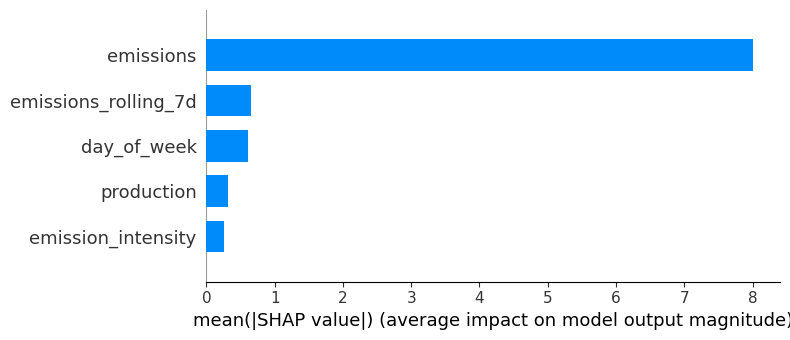

In [5]:
import numpy as np
# Sample data
df = pd.DataFrame({
    'timestamp': pd.date_range(start='2024-01-01', periods=30, freq='D'),
    'emissions': np.random.randint(80, 120, size=30),
    'production': np.random.randint(40, 60, size=30)
})
df['target'] = df['emissions'] + np.random.normal(0, 5, size=30)  # Simulated target

# Feature engineering
df_fe = engineer_features(df)

# Feature selection
X_selected, selected_cols = select_top_features(df_fe, target_col='target', k=5)
print("Selected features:", selected_cols.tolist())

# SHAP validation
explain_with_shap(X_selected, df_fe['target'])
